# Notebook 7: Knowledge Graph Construction & Analytics

**Master's Final Dissertation | Pipeline Stage 7 of 7**

## 1. Project Context

This notebook represents the final stage of a multi-step pipeline designed to extract and structure scientific knowledge from the arXiv materials science corpus.

* **Upstream:** Notebooks 1–4 handled corpus building and text normalization. Notebooks 5.1 and 5.2 utilized **Gemma 2.5 9B** for claim extraction and entity recognition.
* **Current (7):** This stage employs **Qwen 3 8B** to perform **Relation Extraction (RE)** on the claims and entities identified previously, culminating in the construction of the final **Knowledge Graph (KG)**.

---

## 2. Objectives

* **Semantic Relation Extraction:** Use LLM-based reasoning to identify directional relationships between materials, properties, conditions, and methods.
* **Parallel Inference:** Implement optimized batch processing to maximize GPU throughput during the extraction phase.
* **Graph Construction:** Assemble a directed multi-graph using `NetworkX` to represent the complex interplay of scientific facts.
* **Advanced Analytics:** Perform community detection (Louvain method) and centrality analysis to identify research "hubs" and topic clusters.
* **Multi-Modal Visualization:** Generate interactive 3D visualizations (PyVis) and focused neighborhood views (Plotly) for qualitative result inspection.

---

## 3. Technical Stack

| Component | Technology |
| --- | --- |
| **Inference Engine** | Qwen 3 8B (4-bit Quantization via `bitsandbytes`) |
| **Graph Logic** | `NetworkX` |
| **Analytics** | `community-louvain`, `scikit-learn` |
| **Visualization** | `PyVis`, `Plotly`, `Matplotlib` (Shell Layout) |


## 1. Environment Setup

We begin by installing the necessary dependencies. The libraries are categorized as follows:
* **LLM Inference:** `transformers`, `accelerate`, `bitsandbytes` (required for Qwen 3 8B).
* **Graph Construction & Visualization:** `networkx`, `pyvis`, `plotly`.
* **Entity Resolution & String Matching:** `python-Levenshtein`, `fuzzywuzzy`, `sentence-transformers`, `scikit-learn`.



In [1]:
%%capture
!pip install -q transformers accelerate torch bitsandbytes
!pip install -q networkx pyvis plotly python-Levenshtein fuzzywuzzy
!pip install -q sentence-transformers scikit-learn

## 2. Imports and Configuration

We import the essential libraries for graph manipulation (`networkx`), visualization (`pyvis`, `plotly`), and deep learning (`torch`, `transformers`). We also mount Google Drive to access the intermediate datasets generated in Notebooks 5.1 (Claims) and 5.2 (Entities).



In [48]:
import json
from itertools import islice
import re
import torch
import networkx as nx
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from typing import List, Dict, Any, Tuple
from collections import defaultdict, Counter
import unicodedata # Added for Unicode normalization

# Fuzzy matching for Entity Resolution
from fuzzywuzzy import fuzz
from Levenshtein import distance as levenshtein_distance

# Visualization Tools
import seaborn as sns
import matplotlib.pyplot as plt
from pyvis.network import Network
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import HTML, display
import networkx as nx

# Transformers & Model Configuration
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from accelerate import init_empty_weights, load_checkpoint_and_dispatch


# Mount external storage
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.1 Hardware Verification
Ensuring the GPU is correctly detected and available for Qwen 3 8B inference.

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU count: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("WARNING: No GPU detected. Inference will be extremely slow.")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU count: 1
GPU 0: Tesla T4


## 3. Data Configuration

We define the file paths for the input data required for graph construction:
1.  **Normalized Corpus:** The cleaned text data from Notebook 4.
2.  **Processed Claims & Entities:** The output from Notebook 5.2 (Entity Extraction), which contains the claims and the entities identified within them.

> **Note:** The paths below are configured for Google Colab. If running on Kaggle or a local machine, adjust the paths accordingly.

In [4]:
# Option 1: Kaggle Environment (Uncomment if needed)
# CORPUS_PATH = "/kaggle/input/corpus/bis2_corpus_v1_normalized_20260119_130825 (1).json"
# CLAIMS_PATH = "/kaggle/input/entities/Qwen_3_8B_ProcessedClaimsAndEntities_20260126_182401.json"


# Ensure drive is mounted
if not Path('/content/drive').exists():
    drive.mount('/content/drive')

# Define Paths
CORPUS_PATH = "/content/drive/MyDrive/TFM/data/corpora/03_normalized/bis2_corpus_v1_normalized_20260119_130825.json"
CLAIMS_PATH = "/content/drive/MyDrive/TFM/data/output/Qwen_3_8B_ProcessedClaimsAndEntities_20260126_182401.json"

# Verify files exist
print(f"Corpus File Exists: {Path(CORPUS_PATH).exists()}")
print(f"Claims File Exists: {Path(CLAIMS_PATH).exists()}")

Corpus File Exists: True
Claims File Exists: True


## 4. Data Loading

We define a helper function to safely load the JSON datasets and perform an initial inspection of the contents to ensure the structure matches our expectations for the Graph Construction phase.


In [5]:
def load_json_file(filepath: str) -> Dict[str, Any]:
    """Load JSON file safely."""
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

# Load corpus
corpus_data = load_json_file(CORPUS_PATH)
papers = corpus_data.get('papers', [])
print(f"Loaded {len(papers)} papers from corpus")

# Load claims
# Handling both list format and dictionary wrapper format
claims_data = load_json_file(CLAIMS_PATH)
if isinstance(claims_data, dict) and 'claims' in claims_data:
    claims = claims_data['claims']
else:
    claims = claims_data
print(f"Loaded {len(claims)} claims")

# Display samples for verification
print("\n--- Sample Paper (First 500 chars) ---")
print(json.dumps(papers[0], indent=2)[:500] + "...")

print("\n--- Sample Claim ---")
print(json.dumps(claims[0], indent=2))

Loaded 122 papers from corpus
Loaded 730 claims

--- Sample Paper (First 500 chars) ---
{
  "arxiv_id": "2406.01263v2",
  "entry_id": "http://arxiv.org/abs/2406.01263v2",
  "doi": "10.7566/JPSJ.93.074707",
  "title": "Pb Substitution Effects on Lattice and Electronic System of the BiS2-based Superconductors La(O F)BiS2",
  "abstract": "We examined the effect of Pb substitution in the layered superconductor LaO0.5F0.5Bi1-xPbxS2 (x=0~0.15) through the measurements of the resistivity, thermal expansion, specific heat, and Seebeck coefficient. These transport and thermal properties sho...

--- Sample Claim ---
{
  "claim_id": "claim_0001",
  "arxiv_id": "2406.01263v2",
  "claim_text": "Measurements of resistivity, thermal expansion, specific heat, and Seebeck coefficient show anomalies at certain temperatures (T*) for LaO0.5F0.5Bi1-xPbxS2 (x\u22650.08).",
  "metadata": {
    "Source ID": "2406.01263v2",
    "Study Type": "Experimental",
    "Epistemic Type": "Observation",
    "Polarity": 

## 4. Model Initialization

We initialize the **Qwen 3 8B** model using 4-bit quantization via `bitsandbytes`. This configuration is essential for fitting the model into GPU memory while maintaining inference performance.

**Configuration Details:**
* **Quantization:** 4-bit (NF4) to reduce memory footprint.
* **Compute Dtype:** `float16` ensures compatibility with T4/L4 GPUs.
* **Attention Implementation:** `sdpa` (Scaled Dot Product Attention) is enabled for faster processing.
* **Device Map:** `auto` allows the library to automatically distribute layers across available GPUs.


In [10]:
MODEL_NAME = "Qwen/Qwen3-8B"

# Configure 4-bit quantization for memory efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16 # Ensures T4 compatibility
)

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

print("Loading model with multi-GPU support...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",  # Automatically distribute across GPUs
    trust_remote_code=True,
    torch_dtype=torch.float16, # Ensures T4 compatibility
    attn_implementation="sdpa" # Optimized attention mechanism
)

print(f"\nModel loaded successfully!")
print(f"Device map: {model.hf_device_map}")

Loading tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Loading model with multi-GPU support...


config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.19G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]


Model loaded successfully!
Device map: {'': 0}


## 5. Relation Extraction System Prompt

In [11]:
SYSTEM_PROMPT_1 = """

## ALLOWED RELATIONS

Determine the relation strictly from the **entity label pairs** provided in the input:
`Material, Property, State, Condition, Method, Measurement Value`

### **1. Material Definition**
Describes intrinsic characteristics of a material. ONLY the Material with a valid FORMULA fits here.
* Material → State : relation **"EXHIBITS_STATE"**
* Material → Property : relation **"HAS_PROPERTY"**

### **2. Dependencies**

Conditions can either describe the observation or methodology setting or act as a driver that changes a property or state.
* State → Condition : relation **"STATE_UNDER_CONDITION"** — state observed under a specific setting.
* Property → Condition : relation **"PROPERTY_UNDER_CONDITION"** — property observed under a specific setting.
* Method → Condition : relation **"EXPERIMENT_CONDITIONS"** — experimental conditions applied during the measurement.

These relations CAN INCLUDE (not mandatory) an additional field "effect" with one of [`"increase"`, `"decrease"`, `"enhance"`, `"suppress"`, `"no_change"`, `"unknown"`] if explicitly stated in the claim.

### **3. Measurements & Values**
Describes how properties or conditions are quantified or measured.
* Property → Measurement Value : relation **"HAS_PROPERTY_VALUE"** (e.g., "Tc onset, HAS_PROPERTY_VALUE, 11.1 K")
* Condition → Measurement Value : relation **"HAS_CONDITION_VALUE"**

### **4. Methodology Nature**
How the Techniques relate to the real world, compounds and specs.
* Method → Property : relation **"MEASURES"** or **"DESCRIBES"**
* Method → Material : relation **"SYNTHESIZES"**

---

## EXTRACTION RULES

1. **Entity Priority**: Use the exact strings from the 'entities' list.
2. **Adding Entities**: You can add entities to the "entities" dict if they were missing (ALWAYS adhering to the entity labels list: `Material, Property, State, Condition, Method, Measurement Value`).
3. **Physical Attributes**: If the input contains a 'physical_attributes' dictionary, you CAN map them into the relations. NOT OBLIGATORY: use them ONLY to enhance the content for claims with low number of relations. If they contradict or cause confusion with the entities → IGNORE completely.
4. **CRITICAL - Entity Usage**: Extract ALL meaningful relations from the entities provided. Some entities may not have valid relations according to the allowed relations - this is acceptable. Do NOT force connections that violate the relation rules.
5. **Derived Properties**: If one property is calculated from another (e.g., "c/a" is derived from "lattice constants a and c"), treat them as separate properties ONLY if they both appear in the entities list. Connect the Method to the directly measured property.
6. **Use ONLY the allowed relations** specified above.
7. **Unidirectional Strictness**: You must strictly adhere to the Subject → Object direction defined in the mapping rules.
8. **REVISE THOROUGHLY** if the entities in the triplets ADHERE to the allowed relations.

---

## OUTPUT FORMAT

Return ONLY valid JSON with this structure:
```json
{
  "claim_id": "...",
  "claim_text": "...",
  "metadata": {...},
  "entities": [...],
  "triplets": [
    {
      "subject": "entity text",
      "relation": "ALLOWED_RELATION",
      "object": "entity text",
      "effect": "optional_effect_value"
    }
  ]
}
```
"""

## 5. Sample Batch

In [7]:
claims_batch = [
  {
    "claim_id": "claim_1",
    "arxiv_id": "synthetic",
    "claim_text": "The crystal structure of CeO1-xFxBiS2 is possibly optimized for the appearance of both ferromagnetism and bulk superconductivity due to high F concentration (x > 0.7)",
    "metadata": {
      "Source ID": "synthetic",
      "Study Type": "Experimental",
      "Epistemic Type": "Inference",
      "Polarity": "Positive"
    },
    "physical_attributes": {
      "Subject": "CeO1-xFxBiS2",
      "Driver": "high F concentration",
      "Effect": "appearance of both ferromagnetism and bulk superconductivity"
    },
    "entities": [
      {"text": "CeO1-xFxBiS2", "label": "Material"},
      {"text": "crystal structure", "label": "Property"},
      {"text": "ferromagnetism", "label": "State"},
      {"text": "bulk superconductivity", "label": "State"},
      {"text": "high F concentration", "label": "Condition"},
      {"text": "x > 0.7", "label": "Measurement Value"}
    ]
  },
  {
    "claim_id": "claim_2",
    "arxiv_id": "synthetic",
    "claim_text": "All NdO1-xFxBiS2 samples (x=0.1-0.9) exhibit superconductivity confirmed by DC magnetic susceptibility and electrical transport measurements",
    "metadata": {
      "Source ID": "synthetic",
      "Study Type": "Experimental",
      "Epistemic Type": "Observation",
      "Polarity": "Neutral"
    },
    "physical_attributes": {
      "Subject": "NdO1-xFxBiS2",
      "Effect": "superconductivity"
    },
    "entities": [
      {"text": "NdO1-xFxBiS2", "label": "Material"},
      {"text": "x=0.1-0.9", "label": "Measurement Value"},
      {"text": "superconductivity", "label": "State"},
      {"text": "DC magnetic susceptibility", "label": "Method"},
      {"text": "electrical transport measurements", "label": "Method"}
    ]
  },
  {
    "claim_id": "claim_3",
    "arxiv_id": "synthetic",
    "claim_text": "The energy scales of the interband transitions in F-substituted NdOBiS2 superconducting single crystals are well reproduced by first-principles calculations",
    "metadata": {
      "Source ID": "synthetic",
      "Study Type": "Computational",
      "Epistemic Type": "Observation",
      "Polarity": "Neutral"
    },
    "physical_attributes": {
      "Subject": "F-substituted NdOBiS2",
      "Effect": "energy scales of interband transitions reproduced"
    },
    "entities": [
      {"text": "energy scales", "label": "Property"},
      {"text": "interband transitions", "label": "Property"},
      {"text": "F-substituted NdOBiS2", "label": "Material"},
      {"text": "first-principles calculations", "label": "Method"}
    ]
  },
  {
    "claim_id": "claim_4",
    "arxiv_id": "synthetic",
    "claim_text": "The Tc of NdO0.7F0.3BiS2 increases with increasing Pb concentration up to 6%",
    "metadata": {
      "Source ID": "synthetic",
      "Study Type": "Experimental",
      "Epistemic Type": "Observation",
      "Polarity": "Positive"
    },
    "physical_attributes": {
      "Subject": "NdO0.7F0.3BiS2",
      "Driver": "increasing Pb concentration",
      "Effect": "Tc increases"
    },
    "entities": [
      {"text": "Tc", "label": "Property"},
      {"text": "NdO0.7F0.3BiS2", "label": "Material"},
      {"text": "increasing Pb concentration", "label": "Condition"},
      {"text": "6%", "label": "Measurement Value"}
    ]
  },
  {
    "claim_id": "claim_5",
    "arxiv_id": "synthetic",
    "claim_text": "With increasing Nd concentration, the length of the a axis in Ce1-xNdxO0.5F0.5BiS2 decreased",
    "metadata": {
      "Source ID": "synthetic",
      "Study Type": "Experimental",
      "Epistemic Type": "Observation",
      "Polarity": "Negative"
    },
    "physical_attributes": {
      "Subject": "Ce1-xNdxO0.5F0.5BiS2",
      "Driver": "increasing Nd concentration",
      "Effect": "length of the a axis decreased"
    },
    "entities": [
      {"text": "increasing Nd concentration", "label": "Condition"},
      {"text": "length of the a axis", "label": "Property"},
      {"text": "Ce1-xNdxO0.5F0.5BiS2", "label": "Material"}
    ]
  },
  {
    "claim_id": "claim_6",
    "arxiv_id": "synthetic",
    "claim_text": "Electrical resistivity measurements indicate that under applied magnetic field both Tc onset and Tc (ρ =0) decrease",
    "metadata": {
      "Source ID": "synthetic",
      "Study Type": "Experimental",
      "Epistemic Type": "Observation",
      "Polarity": "Negative"
    },
    "physical_attributes": {
      "Driver": "applied magnetic field",
      "Effect": "Tc onset and Tc (ρ =0) decrease"
    },
    "entities": [
      {"text": "Electrical resistivity measurements", "label": "Method"},
      {"text": "applied magnetic field", "label": "Condition"},
      {"text": "Tc onset", "label": "Property"},
      {"text": "Tc (ρ =0)", "label": "Property"}
    ]
  }
]


## 6. Response Processing

Since Large Language Models (LLMs) often include "thinking" traces (`<think>` tags) or Markdown code fences in their output, we need a robust parsing function. The `clean_and_parse_json` utility ensures we extract valid JSON objects regardless of the surrounding conversational text.


In [9]:

def clean_and_parse_json(response_text: str) -> Dict[str, Any]:
    """
    Robustly extracts JSON from a model response, handling <think> tags
    and Markdown code blocks.

    Args:
        response_text (str): The raw string output from the LLM.

    Returns:
        dict: The parsed JSON object.

    Raises:
        ValueError: If no valid JSON object is found.
    """
    # 1. Remove thinking blocks (handling both <think> and <thinking>)
    # This regex removes everything between <think> and </think> (including newlines)
    response_text = re.sub(r'<think(?:ing)?>(.*?)</think(?:ing)?>', '', response_text, flags=re.DOTALL)

    # 2. Look for JSON inside Markdown code blocks (```json ... ```)
    json_match = re.search(r'```json\s*({.*?})\s*```', response_text, re.DOTALL)
    if json_match:
        return json.loads(json_match.group(1))

    # 3. Fallback: Look for generic code blocks
    json_match = re.search(r'```\s*({.*?})\s*```', response_text, re.DOTALL)
    if json_match:
        return json.loads(json_match.group(1))

    # 4. Brute force: Find the first '{' and the last '}'
    # This ignores any text before the JSON starts or after it ends
    start_idx = response_text.find('{')
    end_idx = response_text.rfind('}')

    if start_idx != -1 and end_idx != -1:
        json_str = response_text[start_idx : end_idx + 1]
        return json.loads(json_str)

    raise ValueError("No JSON object found in response")

## 7. Relation Extraction Logic

We define the `extract_relations_batch` function to process claims in batches. This function:
1.  Constructs the prompt using the `SYSTEM_PROMPT` (defined in the next section) and the claim data.
2.  Invokes **Qwen 3 8B** to generate a response.
3.  Uses the `clean_and_parse_json` utility to extract the structured output.
4.  Handles errors gracefully by preserving the raw response if parsing fails.


In [28]:
def extract_relations_batch(claims_batch: List[Dict],
                            SYSTEM_PROMPT: str,
                            model: AutoModelForCausalLM,
                            tokenizer: AutoTokenizer,
                            max_new_tokens: int = 2048,
                            enable_streaming: bool = False,
                            enable_thinking: bool = False) -> List[Dict]:
    """
    Extract relations for a batch of claims using the LLM.

    Args:
        claims_batch: List of claim dictionaries.
        model: The language model.
        tokenizer: The tokenizer.
        max_new_tokens: Maximum tokens to generate.
        enable_streaming: If True, stream the generation token by token.
        enable_thinking: If True, enable model thinking/reasoning mode.

    Returns:
        List[Dict]: A list of processed claims with extracted triplets.
    """
    results = []

    # Ensure SYSTEM_PROMPT is defined in the scope
    if 'SYSTEM_PROMPT' not in globals():
        raise NameError("SYSTEM_PROMPT is not defined. Please define the system prompt before running extraction.")

    for claim in tqdm(claims_batch, desc="Extracting relations"):
        # Prepare input
        claim_json = json.dumps(claim, indent=2)
        persona_pattern = """You are an automated Relation Extraction System for Materials Science with advanced reasoning capabilities.
Before providing your final JSON output, you should think through the problem step by step. Wrap your reasoning in <thinking> tags.
After your reasoning, provide the final JSON output.
"""
        # Modify system prompt based on thinking mode
        if enable_thinking:
            system_content = persona_pattern + SYSTEM_PROMPT
        else:
            # Explicitly discourage thinking if disabled (optional, depends on model behavior)
            system_content = "/no_think \n" + persona_pattern + SYSTEM_PROMPT + "\n/no_think"

        user_message = f"Extract relations from this claim:\n\n{claim_json}"

        messages = [
            {"role": "system", "content": system_content},
            {"role": "user", "content": user_message}
        ]
        # Tokenize
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )

        inputs = tokenizer([text], return_tensors="pt").to(model.device)

        # Generate
        with torch.no_grad():
            if enable_streaming:
                print(f"\n{'='*80}")
                print(f"Streaming output for {claim.get('claim_id', 'unknown')}:")
                print(f"{'='*80}")

                from transformers import TextStreamer
                streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    temperature=0.1,
                    do_sample=False,
                    pad_token_id=tokenizer.eos_token_id,
                    streamer=streamer
                )
            else:
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    temperature=0.1,
                    do_sample=False,
                    pad_token_id=tokenizer.eos_token_id
                )

        # Decode response
        # Calculate the length of input tokens to slice them off the output
        input_length = inputs['input_ids'].shape[1]
        response = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=True)

        try:
            # Use the robust cleaner defined in Section 7
            extracted_data = clean_and_parse_json(response)

            # Preserve metadata
            if 'claim_id' not in extracted_data:
                extracted_data['claim_id'] = claim.get('claim_id')

            results.append(extracted_data)

        except (json.JSONDecodeError, ValueError) as e:
            print(f"JSON Parse Error for {claim.get('claim_id')}: {e}")

            # Create a fallback entry so the claim isn't lost
            fallback_claim = claim.copy()
            fallback_claim['triplets'] = []
            fallback_claim['extraction_error'] = str(e)
            fallback_claim['raw_response'] = response  # Save raw response for post-mortem debugging

            results.append(fallback_claim)

    return results

## 8. Validation: Sample Extraction

We perform a "dry run" on a small subset of claims. By enabling `streaming=True`, we can watch the model's generation process. This is crucial for verifying that the model is following instructions (e.g., producing valid JSON) before committing to a long-running batch process.


### 8.1 Suboptimal Results from Sample Inference (KQNCrqKI55EY)

The sample extraction in cell `KQNCrqKI55EY` reveals some suboptimal outputs based on the defined `SYSTEM_PROMPT_1`. Specifically, for `claim_0001`:

*   **Incorrect Relation for Properties to State**: The model generates `HAS_PROPERTY_VALUE` relations between entities labeled as `Property` (e.g., "resistivity", "thermal expansion") and an entity labeled as `State` ("anomalies"). According to `SYSTEM_PROMPT_1`, `HAS_PROPERTY_VALUE` is defined as `Property → Measurement Value`.

    *   Example: `resistivity --[HAS_PROPERTY_VALUE]--> anomalies`

*   **Incorrect Relation for Condition to State**: The model generates a `STATE_UNDER_CONDITION` relation between a `Condition` (`x>=0.08`) and a `State` (`anomalies`). While `STATE_UNDER_CONDITION` is a valid relation, its subject and object are inverted in this triplet compared to the expected `State → Condition` (`STATE_UNDER_CONDITION`).

    *   Example: `x≥0.08 --[STATE_UNDER_CONDITION]--> anomalies` (Expected: `anomalies --[STATE_UNDER_CONDITION]--> x≥0.08`)

These discrepancies indicate that while the model attempts to generate relations, it does not strictly adhere to the defined `Subject → Object` and `Label Type` constraints outlined in `SYSTEM_PROMPT_1`. This highlights the need for careful prompt engineering or post-processing to ensure adherence to the desired schema.

In [29]:

# 1. Select a small sample for validation (e.g., first 3 claims)
sample_batch = claims[:3]


# 32 Execution: Streaming Mode
print("\n" + "="*80)
print("SAMPLE BATCH EXTRACTION WITH STREAMING MODE ENABLED")
print("="*80 + "\n")

sample_results_streaming = []

# Process one by one to visualize streaming clearly
for i in range(len(sample_batch)):
    batch = sample_batch[i:i+1]

    # Run extraction
    extracted = extract_relations_batch(
        batch,
        SYSTEM_PROMPT_1,
        model,
        tokenizer,
        max_new_tokens=2048,
        enable_streaming=True,
        enable_thinking=False
    )

    sample_results_streaming.extend(extracted)

    # Print the clean result for this claim
    result_item = extracted[0]
    print(f"\n{'='*80}")
    print(f"CLAIM: {batch[0].get('claim_text', 'N/A')}")
    print(f"\nEXTRACTED TRIPLETS:")

    triplets = result_item.get('triplets', [])
    if not triplets:
        print("  (No triplets found)")

    for triplet in triplets:
        # Format the effect string if it exists
        effect_str = f" [effect: {triplet.get('effect')}]" if triplet.get('effect') else ""

        # safely get subject/object/relation
        subj = triplet.get('subject', 'Unknown')
        rel = triplet.get('relation', 'Unknown')
        obj = triplet.get('object', 'Unknown')

        print(f"  • {subj} --[{rel}]--> {obj}{effect_str}")

    print(f"{'='*80}\n")


SAMPLE BATCH EXTRACTION WITH STREAMING MODE ENABLED



Extracting relations:   0%|          | 0/1 [00:00<?, ?it/s]


Streaming output for claim_0001:
<think>

</think>

```json
{
  "claim_id": "claim_0001",
  "claim_text": "Measurements of resistivity, thermal expansion, specific heat, and Seebeck coefficient show anomalies at certain temperatures (T*) for LaO0.5F0.5Bi1-xPbxS2 (x\u22650.08).",
  "metadata": {
    "Source ID": "2406.01263v2",
    "Study Type": "Experimental",
    "Epistemic Type": "Observation",
    "Polarity": "Neutral"
  },
  "entities": [
    {
      "text": "resistivity",
      "label": "Property"
    },
    {
      "text": "thermal expansion",
      "label": "Property"
    },
    {
      "text": "specific heat",
      "label": "Property"
    },
    {
      "text": "Seebeck coefficient",
      "label": "Property"
    },
    {
      "text": "anomalies",
      "label": "State"
    },
    {
      "text": "LaO0.5F0.5Bi1-xPbxS2",
      "label": "Material"
    },
    {
      "text": "x\u22650.08",
      "label": "Condition"
    }
  ],
  "triplets": [
    {
      "subject": "resistivity

Extracting relations:   0%|          | 0/1 [00:00<?, ?it/s]


Streaming output for claim_0002:
<think>

</think>

```json
{
  "claim_id": "claim_0002",
  "claim_text": "Large thermal expansion anomalies, specific heat anomalies, and the existence of hystereses in the resistivity, thermal expansion, specific heat, and Seebeck coefficient measurements indicate a first-order structural phase transition at T* in LaO0.5F0.5Bi1-xPbxS2 (x≥0.08).",
  "metadata": {
    "Source ID": "2406.01263v2",
    "Study Type": "Experimental",
    "Epistemic Type": "Inference",
    "Polarity": "Neutral"
  },
  "entities": [
    {
      "text": "thermal expansion anomalies",
      "label": "State"
    },
    {
      "text": "specific heat anomalies",
      "label": "State"
    },
    {
      "text": "hystheses",
      "label": "State"
    },
    {
      "text": "resistivity",
      "label": "Property"
    },
    {
      "text": "thermal expansion",
      "label": "Property"
    },
    {
      "text": "specific heat",
      "label": "Property"
    },
    {
      "text"

Extracting relations:   0%|          | 0/1 [00:00<?, ?it/s]


Streaming output for claim_0003:
<think>

</think>

```json
{
  "claim_id": "claim_0003",
  "claim_text": "The anomalies at T* in LaO0.5F0.5Bi1-xPbxS2 (x\u22650.08) are related to both the lattice system and the electronic system.",
  "metadata": {
    "Source ID": "2406.01263v2",
    "Study Type": "Experimental",
    "Epistemic Type": "Inference",
    "Polarity": "Neutral"
  },
  "entities": [
    {
      "text": "LaO0.5F0.5Bi1-xPbxS2",
      "label": "Material"
    },
    {
      "text": "T*",
      "label": "Property"
    },
    {
      "text": "lattice system",
      "label": "State"
    },
    {
      "text": "electronic system",
      "label": "State"
    },
    {
      "text": "x\u22650.08",
      "label": "Condition"
    }
  ],
  "triplets": [
    {
      "subject": "LaO0.5F0.5Bi1-xPbxS2",
      "relation": "EXHIBITS_STATE",
      "object": "lattice system"
    },
    {
      "subject": "LaO0.5F0.5Bi1-xPbxS2",
      "relation": "EXHIBITS_STATE",
      "object": "electronic sys

## 9. Optimized Relation Extraction

To maximize GPU utilization, we implement a parallelized extraction function. This approach processes a batch of claims simultaneously rather than sequentially.

**Key Optimizations:**
* **Batch Tokenization:** All prompts in a batch are tokenized together with **left-padding** (essential for decoder-only models like Qwen during generation).
* **Single Inference Step:** The model generates responses for the entire batch in one `model.generate()` call.
* **Parallel Decoding:** Responses are decoded and parsed in a vectorized manner where possible.


In [43]:

def extract_relations_parallel(claims_batch: List[Dict],
                               SYSTEM_PROMPT: str,
                               model: AutoModelForCausalLM,
                               tokenizer: AutoTokenizer,
                               max_new_tokens: int = 2048,
                               enable_thinking: bool = False) -> List[Dict]:
    """
    TRUE PARALLEL EXECUTION.
    Processes all claims in the batch simultaneously on the GPU.

    Args:
        claims_batch: List of claim dictionaries.
        model: The language model.
        tokenizer: The tokenizer.
        max_new_tokens: Maximum tokens to generate.
        enable_thinking: If True, enable model thinking/reasoning mode.

    Returns:
        List[Dict]: List of processed claims with extracted triplets.
    """
    # 1. Prepare ALL prompts first
    prompts = []

    for claim in claims_batch:
        claim_json = json.dumps(claim, indent=2)
        persona_pattern = """You are an automated Relation Extraction System for Materials Science with advanced reasoning capabilities.
Before providing your final JSON output, you should think through the problem step by step. Wrap your reasoning in <thinking> tags.
After your reasoning, provide the final JSON output.
"""
        # Modify system prompt if thinking is enabled
        if enable_thinking:
             # Add specific thinking instructions
            sys_prompt =  persona_pattern + SYSTEM_PROMPT
        else:
            # Explicitly disable thinking
            sys_prompt = "/no_think \n" + persona_pattern + SYSTEM_PROMPT + "\n /no_think"

        user_message = f"Extract relations from this claim:\n\n{claim_json}"

        messages = [
            {"role": "system", "content": sys_prompt},
            {"role": "user", "content": user_message}
        ]

        # Apply template but do NOT tokenize yet
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        prompts.append(text)

    # 2. Tokenize the entire batch at once
    # CRITICAL: Ensure left-padding is on for generation
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Save original padding side to restore later if needed
    original_padding_side = tokenizer.padding_side
    tokenizer.padding_side = "left"

    inputs = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,       # Pad shortest prompts to match longest
        truncation=True
    ).to(model.device)

    # 3. Generate for the whole batch simultaneously
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    # Restore padding side (good practice)
    tokenizer.padding_side = original_padding_side

    # 4. Decode all outputs
    # Slice [:, inputs.shape[1]:] removes the input prompt from the output
    generated_ids = outputs[:, inputs['input_ids'].shape[1]:]
    responses = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

    # 5. Parse results
    results = []
    for i, response in enumerate(responses):
        claim = claims_batch[i]
        try:
            # Use the cleaner function defined in Section 7
            extracted_data = clean_and_parse_json(response)

            # Ensure metadata survives
            if 'claim_id' not in extracted_data:
                extracted_data['claim_id'] = claim.get('claim_id')

            results.append(extracted_data)

        except Exception as e:
            # Error handling
            print(f"Error parsing batch item {i} (Claim {claim.get('claim_id')}): {e}")

            # Create fallback
            fallback_claim = claim.copy()
            fallback_claim['triplets'] = []
            fallback_claim['extraction_error'] = str(e)
            fallback_claim['raw_response'] = response

            results.append(fallback_claim)

    return results

### 9.1 New Prompt Engineering

We define the **System Prompt** that governs the behavior of Qwen 3 8B. This prompt has been optimized for:
1.  **Strict Adherence:** It enforces a specific schema of allowed relations (e.g., `HAS_PROPERTY`, `EXHIBITS_STATE`).
2.  **Entity Focus:** It prioritizes linking the pre-extracted entities over interpreting the prose of the claim.
3.  **Inference Speed:** By using "lightweight" instructions and removing the requirement for long chain-of-thought unless necessary, we reduce token generation time.

### Key Changes in System Prompt 2

* **Structure & Visuals:** Replaces descriptive text with a strict **Relation Legality Table** (`Subject | Object | Relation`) to enforce unidirectional constraints and reduce ambiguity.
* **In-Context Learning:** Introduces **Few-Shot Examples** (Input/Output pairs) to demonstrate exact formatting and logic, aiming to reduce inference errors.
* **Entity Constraints:** Shifts from allowing entity creation ("You can add entities") to a **Closed Scope** ("Do not invent new entities").
* **Logic Anchoring:** Enforces a **"Material Anchoring" rule**, requiring all Properties/States to link back to a Material, and strict **Method limitations** (preventing direct links to values/conditions).
* **Reasoning Depth:** Explicitly commands **"Lightweight reasoning"** and **"Entity-Focused Extraction"** (ignoring deep sentence semantics) to optimize speed and reduce hallucinations.

In [37]:
SYSTEM_PROMPT_2 = """

**Task:** Extract entities and relations from scientific claims about materials. Follow strict relation rules and ensure all properties and states are connected to materials. Use lightweight reasoning only.

---

### **Instructions to the LLM**

1. You will receive a **list of entities** labeled as:

```
Material, Property, State, Condition, Method, Measurement Value
```

2. Extract all possible **triplets** using **only these allowed relations** (examples included). If a claim explicitly mentions a change (increase, decrease, enhance, suppress, no_change), include it as `"effect": "<value>"`.

3. **Material anchoring rule:**

   * Every **Property** or **State** must be linked to a **Material** using `HAS_PROPERTY` or `EXHIBITS_STATE`.
   * Do **not** leave states or properties unconnected if a material is mentioned.

4. **Method usage rule:**

   * Methods can only connect via `MEASURES`, `DESCRIBES`, or `SYNTHESIZES`.
   * Methods should **never** connect directly to Measurement Values or Conditions unless explicitly stated.

5. **Relation legality table** (examples included):

| Subject   | Object            | Allowed Relation         | Example                                                        |
| --------- | ----------------- | ------------------------ | -------------------------------------------------------------- |
| Material  | Property          | HAS_PROPERTY             | `NdO0.5F0.5BiS2 --HAS_PROPERTY--> Tc`                          |
| Material  | State             | EXHIBITS_STATE           | `LaO0.5F0.5BiS2 --EXHIBITS_STATE--> superconductivity`         |
| State     | Condition         | STATE_UNDER_CONDITION    | `superconductivity --STATE_UNDER_CONDITION--> high pressure`   |
| Property  | Condition         | PROPERTY_UNDER_CONDITION | `lattice constant --PROPERTY_UNDER_CONDITION--> increasing Se` |
| Method    | Condition         | EXPERIMENT_CONDITIONS    | `XRD --EXPERIMENT_CONDITIONS--> 300 K`                         |
| Property  | Measurement Value | HAS_PROPERTY_VALUE       | `Tc --HAS_PROPERTY_VALUE--> 11.2 K`                            |
| Condition | Measurement Value | HAS_CONDITION_VALUE      | `x=0.7 --HAS_CONDITION_VALUE--> 0.7`                           |
| Method    | Property          | MEASURES / DESCRIBES     | `resistivity measurements --MEASURES--> Tc`                    |
| Method    | Material          | SYNTHESIZES              | `high-pressure synthesis --SYNTHESIZES--> LaO0.5F0.5BiS2`      |

---

6. YOUR FOCUS MUST BE IN THE ENTITIES, NOT IN THE CLAIM ITSELF. Use the claim text as a secondary backup in case of doubts.

### **Output Format (JSON)**

```json
{
  "claim_id": "<claim_id>",
  "triplets": [
    {
      "subject": "<entity_text>",
      "relation": "<ALLOWED_RELATION>",
      "object": "<entity_text>",
      "effect": "<optional, only if explicitly stated>"
    }
  ]
}
```

* Include **all relevant triplets**.
* **Do not invent new entities.**
* **Do not leave properties or states unlinked to a material** if one exists.
* **Use lightweight thinking only.** Avoid long chains of thought — focus on **correct mapping**.

---

### ✅ **Key Notes**

* Always check **entity labels** to pick relations.
* `"effect"` is optional, only include if the claim mentions increase/decrease/enhance/suppress/no_change explicitly.
* Methods are secondary; focus first on **Material → State/Property** and **State/Property → Condition**.
* Be precise.


### FEW-SHOT EXAMPLES
**Input** :
{
  "claim_id": "claim_017",
  "claim_text": "Magnetization measurements reveal that LaO0.5F0.5BiS2 under hydrostatic pressure of 2 GPa shows an increase of Tc onset to 11.2 K",
  "metadata": {"Polarity": "Positive"},
  "entities": [
    {"text": "Magnetization measurements", "label": "Method"},
    {"text": "LaO0.5F0.5BiS2", "label": "Material"},
    {"text": "hydrostatic pressure", "label": "Condition"},
    {"text": "2 GPa", "label": "Measurement Value"},
    {"text": "Tc onset", "label": "Property"},
    {"text": "11.2 K", "label": "Measurement Value"}
  ],}
**Output** :
{
  "claim_id": "claim_017",
  "triplets": [
    {
      "subject": "LaO0.5F0.5BiS2",
      "relation": "HAS_PROPERTY",
      "object": "Tc onset"
    },
    {
      "subject": "Tc onset",
      "relation": "PROPERTY_UNDER_CONDITION",
      "object": "hydrostatic pressure",
      "effect": "increase"
    },
    {
      "subject": "hydrostatic pressure",
      "relation": "HAS_CONDITION_VALUE",
      "object": "2 GPa"
    },
    {
      "subject": "Tc onset",
      "relation": "HAS_PROPERTY_VALUE",
      "object": "11.2 K"
    },
    {
      "subject": "Magnetization measurements",
      "relation": "MEASURES",
      "object": "Tc onset"
    },
    {
      "subject": "Magnetization measurements",
      "relation": "EXPERIMENT_CONDITIONS",
      "object": "hydrostatic pressure"
    }
  ]
}

**Input:**
{
  "claim_id": "claim_9999",
  "arxiv_id": "synthetic_001",
  "claim_text": "Solid-state reaction synthesizes NdO0.5F0.5BiS2, which exhibits a metallic state at room temperature, while a metal-insulator transition appears under low temperature of 50 K.",
  "metadata": {
    "Source ID": "synthetic_001",
    "Study Type": "Experimental",
    "Epistemic Type": "Observation",
    "Polarity": "Neutral"
  },
  "entities": [
    {"text": "Solid-state reaction", "label": "Method"},
    {"text": "NdO0.5F0.5BiS2", "label": "Material"},
    {"text": "metallic state", "label": "State"},
    {"text": "room temperature", "label": "Condition"},
    {"text": "metal-insulator transition", "label": "State"},
    {"text": "low temperature", "label": "Condition"},
    {"text": "50 K", "label": "Measurement Value"}
  ],
  }

**Output:**{
  "claim_id": "claim_9999",
  "triplets": [
    {
      "subject": "Solid-state reaction",
      "relation": "SYNTHESIZES",
      "object": "NdO0.5F0.5BiS2"
    },
    {
      "subject": "NdO0.5F0.5BiS2",
      "relation": "EXHIBITS_STATE",
      "object": "metallic state"
    },
    {
      "subject": "metallic state",
      "relation": "STATE_UNDER_CONDITION",
      "object": "room temperature"
    },
    {
      "subject": "NdO0.5F0.5BiS2",
      "relation": "EXHIBITS_STATE",
      "object": "metal-insulator transition"
    },
    {
      "subject": "metal-insulator transition",
      "relation": "STATE_UNDER_CONDITION",
      "object": "low temperature"
    },
    {
      "subject": "low temperature",
      "relation": "HAS_CONDITION_VALUE",
      "object": "50 K"
    }
  ]
}

**Input:**
```json
{
  "claim_id": "claim_8888",
  "arxiv_id": "synthetic_002",
  "claim_text": "X-ray diffraction measurements show that the lattice constant of the c axis in CeO0.3F0.7BiS2 is suppressed under external pressure of 3 GPa, reaching a value of 13.42 Å.",
  "metadata": {
    "Source ID": "synthetic_002",
    "Study Type": "Experimental",
    "Epistemic Type": "Observation",
    "Polarity": "Negative"
  },
  "entities": [
    {"text": "X-ray diffraction measurements", "label": "Method"},
    {"text": "CeO0.3F0.7BiS2", "label": "Material"},
    {"text": "lattice constant", "label": "Property"},
    {"text": "c axis", "label": "Property"},
    {"text": "external pressure", "label": "Condition"},
    {"text": "3 GPa", "label": "Measurement Value"},
    {"text": "13.42 Å", "label": "Measurement Value"}
  ],
}
```

**Expected Output:**
```json
{
  "claim_id": "claim_888",
  "triplets": [
    {
      "subject": "CeO0.3F0.7BiS2",
      "relation": "HAS_PROPERTY",
      "object": "lattice constant"
    },
    {
      "subject": "lattice constant",
      "relation": "PROPERTY_UNDER_CONDITION",
      "object": "external pressure",
      "effect": "suppress"
    },
    {
      "subject": "external pressure",
      "relation": "HAS_CONDITION_VALUE",
      "object": "3 GPa"
    },
    {
      "subject": "lattice constant",
      "relation": "HAS_PROPERTY_VALUE",
      "object": "13.42 Å"
    },
    {
      "subject": "X-ray diffraction measurements",
      "relation": "MEASURES",
      "object": "lattice constant"
    },
    {
      "subject": "X-ray diffraction measurements",
      "relation": "EXPERIMENT_CONDITIONS",
      "object": "external pressure"
    }
  ]
}


```
## EXTRACTION RULES

1. **Entity Priority**: Use the exact strings from the 'entities' list.
2. ENTITY FOCUSED EXTRACTION -> the goal is to establish relations, not to link them with the sentence meaning. JUST PARSE the entities using the allowed relations.
3. **CRITICAL - Full Entity Usage**: Extract ALL relations from the entities provided BUT do NOT force connections that violate the relations table.
4. **Derived Properties**: If one property is calculated from another (e.g., "c/a" is derived from "lattice constants a and c"), treat them as separate properties ONLY if they both appear in the entities list. Connect the Method to the directly measured property.
5. **Use ONLY the allowed relations** specified in the table above with u**nidirectional Strictness** You must strictly adhere to the Subject → Object direction defined in the mapping rules.
6. **VERIFICATION STEP** : “Check each triplet for RULES COMPLIANCEand allowed relation before finalizing.”


  """

## 10. Validation: Parallel Execution

We test the `extract_relations_parallel` function on the sample batch. This validates that the batch tokenization and simultaneous generation are functioning correctly without errors.


In [ ]:

import time

# 1. Configuration
BATCH_SIZE = 1  # Small batch size for validation
sample_batch = claims[:4]  # Select a slightly larger sample to test batching
print(f"Processing {len(sample_batch)} claims in batches of {BATCH_SIZE}...")

# 2. Execution
start_time = time.time()
all_results = []

for i in range(0, len(sample_batch), BATCH_SIZE):
    batch = sample_batch[i : i + BATCH_SIZE]

    # Run parallel extraction
    batch_results = extract_relations_parallel(
        batch,
        SYSTEM_PROMPT_2,
        model,
        tokenizer,
        max_new_tokens=2048,
        enable_thinking=False # Disabled for speed as per prompt instructions
    )
    all_results.extend(batch_results)

end_time = time.time()
duration = end_time - start_time

# 3. Display Results
print(f"\nCompleted in {duration:.2f} seconds ({duration/len(sample_batch):.2f} s/claim)")
print("="*80)

for res in all_results:
    claim_text = next((c['claim_text'] for c in sample_batch if c.get('claim_id') == res.get('claim_id')), "Unknown Claim")
    print(f"\n[Claim ID: {res.get('claim_id')}]")
    print(f"Text: {claim_text[:100]}...")

    if 'extraction_error' in res:
        print(f"  ERROR: {res['extraction_error']}")
    else:
        triplets = res.get('triplets', [])
        print(f"  Extracted {len(triplets)} triplets:")
        for t in triplets:
            eff = f" [effect: {t['effect']}]" if t.get('effect') else ""
            print(f"   -> {t.get('subject')} --[{t.get('relation')}]--> {t.get('object')}{eff}")

print("\n" + "="*80)

## 11. Full Pipeline Execution

This is the main execution block. It processes the entire dataset in batches, saving results incrementally to a `.jsonl` (JSON Lines) file.

**Key Features:**
* **Resume Capability:** It checks the output file for existing entries and skips them if the process was interrupted.
* **Incremental Saving:** Data is written to disk immediately after each batch, preventing data loss in case of a crash.
* **Memory Safety:** Includes a specific catch for CUDA Out of Memory (OOM) errors.


In [ ]:
# Full extraction.............

# --- Configuration ---
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
BATCH_SIZE = 4  # Adjust based on GPU memory
OUTPUT_FILE = f'simplified_extracted_relations_Qwen3_8B_{timestamp}.jsonl' # .jsonl is best for appending
# ---------------------

# 1. Logic to resume progress (Optional but recommended)
# This checks how many lines are already in the file and skips them
processed_ids = set()
if os.path.exists(OUTPUT_FILE):
    print(f"Found existing progress in {OUTPUT_FILE}. Scanning...")
    with open(OUTPUT_FILE, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data = json.loads(line)
                if 'claim_id' in data:
                    processed_ids.add(data['claim_id'])
            except json.JSONDecodeError:
                continue
    print(f"Resuming: Skipping {len(processed_ids)} already processed claims.")

# Filter out claims that are already done
claims_to_process = [c for c in claims if c.get('claim_id') not in processed_ids]

print(f"Starting processing on {len(claims_to_process)} remaining claims...")

# Initialize the progress bar with the TOTAL number of claims
# 1. CRITICAL TOKENIZER SETUP
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"  # <--- MANDATORY for batch generation

# 2. Main Loop
with tqdm(total=len(claims_to_process), desc="Processing Claims") as pbar:

    for i in range(0, len(claims_to_process), BATCH_SIZE):
        batch = claims_to_process[i:i+BATCH_SIZE]

        try:
            extracted_batch = extract_relations_parallel(
                batch,
                SYSTEM_PROMPT_2,
                model,
                tokenizer,
                max_new_tokens=1024, # Reduced from 2048 to save memory/time
                enable_streaming=False,
                enable_thinking=False
            )
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print(f"\nCRITICAL: Batch size {BATCH_SIZE} is too big for your GPU.")
                print("Please stop, lower BATCH_SIZE, and restart.")
                # Optional: clear cache to try to recover (often easier to just restart script)
                torch.cuda.empty_cache()
                break
            else:
                print(f"Error on batch starting index {i}: {e}")
                continue

        # Save results...
        with open(OUTPUT_FILE, 'a', encoding='utf-8') as f:
            for item in extracted_batch:
                f.write(json.dumps(item, ensure_ascii=False) + '\n')

        pbar.update(len(batch))


    # Optional: Simple progress print
    print(f"Saved {len(extracted_batch)} claims (Total: {len(processed_ids) + i + len(batch)})")

print(f"\nProcessing complete! Results saved to {OUTPUT_FILE}")

Starting processing on 730 remaining claims...


Processing Claims:   0%|          | 0/730 [00:00<?, ?it/s]

Saved 2 claims (Total: 730)

Processing complete! Results saved to simplified_extracted_relations_Qwen3_8B_20260128_124503.jsonl


## 12. Entity Fuzzy Matching & Normalization

In [ ]:
# --- 1. DEFINE MATCHER CLASS (As provided) ---
class EntityMatcher:
    def __init__(self, similarity_threshold=85):
        self.similarity_threshold = similarity_threshold
        self.entity_clusters = defaultdict(list)
        self.canonical_forms = {}

    def normalize_entity(self, text: str) -> str:
        text = re.sub(r'\s+', ' ', text.strip())
        return text

    def compute_similarity(self, s1: str, s2: str) -> float:
        token_sort = fuzz.token_sort_ratio(s1.lower(), s2.lower())
        partial = fuzz.partial_ratio(s1.lower(), s2.lower())
        simple = fuzz.ratio(s1.lower(), s2.lower())
        return 0.4 * token_sort + 0.3 * partial + 0.3 * simple

    def find_canonical_form(self, entity: str, label: str) -> str:
        entity_norm = self.normalize_entity(entity)
        key = (entity_norm.lower(), label)

        if key in self.canonical_forms:
            return self.canonical_forms[key]

        best_match = None
        best_score = 0

        for (existing_entity, existing_label), canonical in self.canonical_forms.items():
            if existing_label == label:
                score = self.compute_similarity(entity_norm, existing_entity)
                if score > best_score and score >= self.similarity_threshold:
                    best_score = score
                    best_match = canonical

        canonical = best_match if best_match else entity_norm

        self.canonical_forms[key] = canonical
        self.entity_clusters[canonical].append(entity_norm)
        return canonical

    def get_statistics(self) -> Dict:
        # (Include your stats code here)
        return {}

# --- 2. LOAD AND MERGE DATA (CORRECTED) ---

print("Loading data...")
# Load Claims (Standard JSON)
with open('/kaggle/input/entities/Qwen_3_8B_ProcessedClaimsAndEntities_20260126_182401.json', 'r') as f:
    claims_data = json.load(f)

# Load Relations (JSONL - Line by Line)
relations_list = []
with open('/kaggle/input/relations/simplified_extracted_relations_Qwen3_8B_20260128_124503.jsonl', 'r') as f:
    for line in f:
        line = line.strip()
        if line:  # Skip empty lines
            parsed_line = json.loads(line)

            # HANDLE BATCHING:
            # If the line contains a LIST of claims, extend our main list.
            # If it contains a single claim DICT, append it.
            if isinstance(parsed_line, list):
                relations_list.extend(parsed_line)
            else:
                relations_list.append(parsed_line)

print(f"Loaded {len(relations_list)} extracted relations.")

# Convert relations list to a dict for fast lookup
relations_map = {item['claim_id']: item['triplets'] for item in relations_list}

print("Merging relations into claims...")
for claim in claims_data:
    c_id = claim.get('claim_id')
    # Insert triplets as the last key:value pair
    claim['triplets'] = relations_map.get(c_id, [])

# --- 3. NORMALIZE ENTITIES AND TRIPLETS ---

matcher = EntityMatcher(similarity_threshold=85)

print("Normalizing entities and updating triplets...")
for claim in tqdm(claims_data):
    # Dictionary to map 'Original Text' -> 'Canonical Text' for this specific claim
    # We need this because triplets don't have labels, so we rely on the entity list
    claim_local_map = {}

    # A. Normalize Entities List
    for entity in claim.get('entities', []):
        original_text = entity['text']
        label = entity['label']

        # Get canonical form
        canonical = matcher.find_canonical_form(original_text, label)

        # Store in entity
        entity['canonical'] = canonical

        # Add to local map for the triplets to use
        claim_local_map[original_text] = canonical
        # Also map the normalized version just in case
        claim_local_map[matcher.normalize_entity(original_text)] = canonical

    # B. Normalize Triplets
    # We update the Subject and Object using the map we built from the entities
    for triplet in claim.get('triplets', []):
        subj = triplet['subject']
        obj = triplet['object']

        # Attempt to find canonical form in our local map
        # If not found (rare, but happens if extraction missed an entity), keep original
        if subj in claim_local_map:
            triplet['subject_canonical'] = claim_local_map[subj]
        else:
            # Fallback: just basic string cleaning
            triplet['subject_canonical'] = matcher.normalize_entity(subj)

        if obj in claim_local_map:
            triplet['object_canonical'] = claim_local_map[obj]
        else:
            triplet['object_canonical'] = matcher.normalize_entity(obj)

# --- 4. SAVE RESULT ---

from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = f'/kaggle/working/Merged_Normalized_Claims_{timestamp}.json'
with open(output_path, 'w') as f:
    json.dump(claims_data, f, indent=2)

print(f"Process complete. Saved to {output_path}")

Loading data...
Loaded 730 extracted relations.
Merging relations into claims...
Normalizing entities and updating triplets...


100%|██████████| 730/730 [00:31<00:00, 23.50it/s]

Process complete. Saved to /kaggle/working/Merged_Normalized_Claims_20260128_171451.json


## 13. Enriched corpus storage

In [ ]:
# --- 1. SETUP PATHS ---

# # The Output from the previous step (COMMENT UNCOMMENT DEPENDING ON DTHE ENVIRONMENT)
CLAIMS_PATH = "/content/drive/MyDrive/TFM/data/output/Merged_Normalized_Claims_20260128_171451.json"
# CLAIMS_PATH = "/kaggle/working/Merged_Normalized_Claims_20260128_171451.json"
# Your original corpus path
CORPUS_PATH = "/content/drive/MyDrive/TFM/data/corpora/03_normalized/bis2_corpus_v1_normalized_20260119_130825.json"
# CORPUS_PATH = '/kaggle/input/corpus/bis2_corpus_v1_normalized_20260119_130825 (1).json'

# --- 2. LOAD DATA ---
print("Loading datasets...")
with open(CLAIMS_PATH, 'r') as f:
    claims_data = json.load(f)

with open(CORPUS_PATH, 'r') as f:
    corpus = json.load(f)

# --- 3. INDEX CLAIMS BY ARXIV_ID ---
# We group claims because one paper might have produced multiple claims
claims_by_paper = defaultdict(list)
for claim in claims_data:
    # keying by arxiv_id to match the corpus structure
    aid = claim.get('arxiv_id')
    if aid:
        claims_by_paper[aid].append(claim)

print(f"Mapped claims for {len(claims_by_paper)} unique papers.")

# --- 4. ENRICH CORPUS ---
print("Enriching corpus papers...")
enrichment_count = 0

for paper in corpus['papers']:
    aid = paper.get('arxiv_id')

    # If we have extracted data for this paper, attach it
    if aid in claims_by_paper:
        # We store the detailed claims (including triplets/entities)
        # under a new key: 'extracted_data'
        paper['extracted_data'] = claims_by_paper[aid]
        enrichment_count += 1
    else:
        paper['extracted_data'] = []

# --- 5. UPDATE METADATA ---
current_time = datetime.datetime.now().isoformat()
corpus['metadata']['updated_at'] = current_time
corpus['metadata']['corpus_stage'] = "enriched_with_relations"
corpus['metadata']['enrichment_stats'] = {
    "papers_enriched": enrichment_count,
    "total_claims_integrated": len(claims_data)
}

# --- 6. SAVE ENRICHED CORPUS ---
timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"bis2_corpus_v1_enriched_{timestamp_str}.json"
output_path = f"/kaggle/working/{output_filename}"

with open(output_path, 'w') as f:
    json.dump(corpus, f, indent=2)

print(f"Success! Enriched corpus stored at: {output_path}")

Loading datasets...
Mapped claims for 121 unique papers.
Enriching corpus papers...
Success! Enriched corpus stored at: /kaggle/working/bis2_corpus_v1_enriched_20260128_172557.json


### Corpus preview for validation

In [47]:
import json

def truncate(value, max_len=120):
    """Truncate long strings for display."""
    s = str(value)
    return s if len(s) <= max_len else s[:max_len] + " ... [truncated]"

def preview_structure(obj, indent=0, max_items=1):
    space = " " * indent

    if isinstance(obj, dict):
        print(f"{space}{{")
        for k, v in obj.items():
            print(f"{space}  '{k}': ", end="")

            if isinstance(v, (dict, list)):
                print(type(v).__name__)
                preview_structure(v, indent + 4, max_items)
            else:
                print(truncate(v))
        print(f"{space}}}")

    elif isinstance(obj, list):
        print(f"{space}[list with {len(obj)} items]")
        for i, item in enumerate(obj[:max_items]):
            print(f"{space}  ├─ item {i}: {type(item).__name__}")
            preview_structure(item, indent + 6, max_items)

        if len(obj) > max_items:
            print(f"{space}  └─ ... {len(obj)-max_items} more items")

    else:
        print(f"{space}{truncate(obj)}")


# -------- LOAD YOUR FILE --------
corpus = "/content/drive/MyDrive/TFM/data/corpora/04_enriched/bis2_corpus_v1_enriched_20260128_172557.json"
# corpus = "/kaggle/working/bis2_corpus_v1_enriched_20260128_172557.json"
with open(corpus, "r", encoding="utf-8") as f:
    data = json.load(f)

print("\n===== DATASET STRUCTURE PREVIEW =====\n")
preview_structure(data)



===== DATASET STRUCTURE PREVIEW =====

{
  'metadata': dict
    {
      'description': BiS2/BiCh2 corpus with full text normalization. Applied: Unicode fixes, PUA artifact cleaning, LaTeX math conversion, Su ... [truncated]
      'corpus_stage': enriched_with_relations
      'corpus_version': v1_normalized
      'created_at': 2026-01-14T10:20:41.126088
      'total_papers': 122
      'queries_used': list
        [list with 7 items]
          ├─ item 0: dict
              {
                'name': Core_Family_Terms
                'query': (all:BiS2 OR all:BiCh2 OR all:BiSe2) AND (all:superconductor OR all:superconductivity)
              }
          └─ ... 6 more items
      'search_strategy': Targeted terms via Arxic API. No exclusions.
      'description_detail': The run_corpus_search wrapper function executes the batch download process for the provided queries and reports the fina ... [truncated]
      'updated_at': 2026-01-28T17:25:57.176039
      'extraction_logic': Regex v3.1 (S

## 13. Statistical Overview

Before constructing the full Knowledge Graph, we analyze the distribution of extracted elements. This helps identify:
* **Dominant Materials:** Which materials appear most frequently as subjects.
* **Relation Balance:** Whether the model is biased toward specific relation types (e.g., `HAS_PROPERTY`).
* **Target Entities:** The most common properties or conditions being measured.

Graph analytics summary saved to: /content/drive/MyDrive/TFM/data/output/graph/graph_analytics_summary_20260130_134329.png


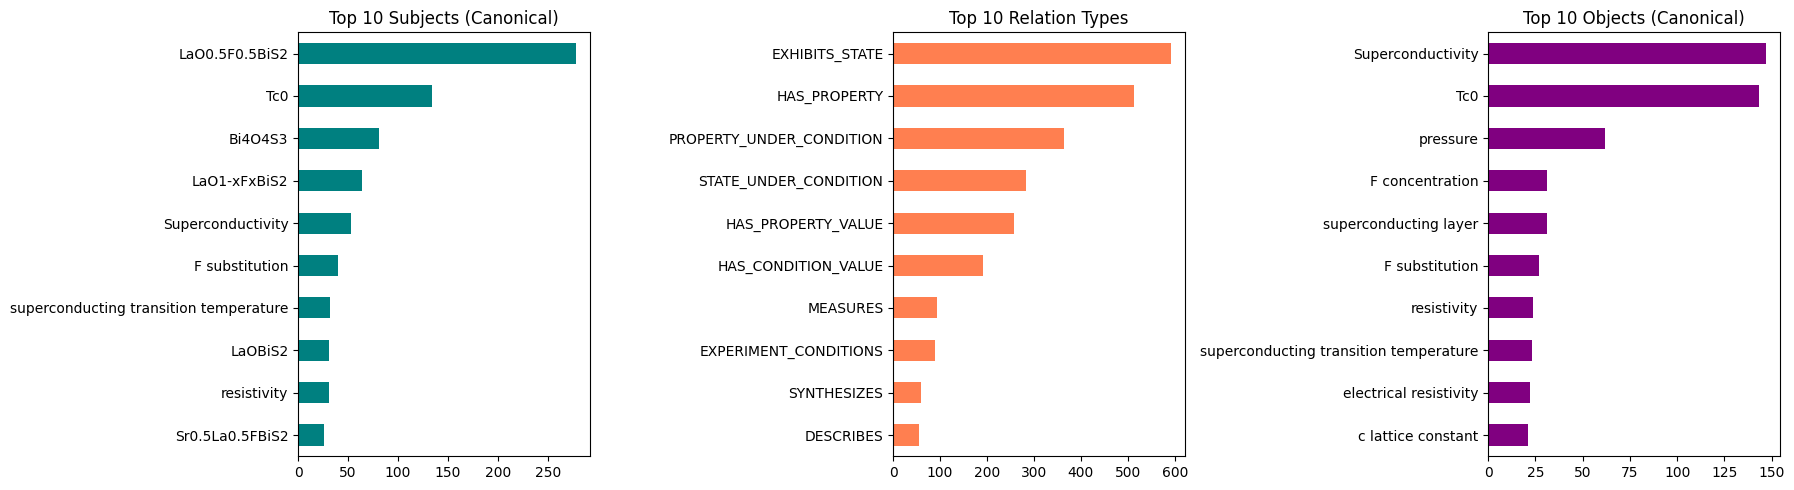

In [58]:
# --- 1. DATA COLLECTION FOR STATS ---
import pandas as pd

all_subjects = []
all_relations = []
all_objects = []

# If running this cell independently, ensure 'data' is loaded first:
# with open(ENRICHED_CORPUS_PATH, 'r') as f:
#     data = json.load(f)

for article in data['papers']:
    for claim in article.get('extracted_data', []):
        for triplet in claim.get('triplets', []):
            subject = triplet.get('subject_canonical') or triplet.get('subject')
            object_ = triplet.get('object_canonical') or triplet.get('object')
            relation = triplet.get('relation')

            if subject:
                all_subjects.append(subject)
            if object_:
                all_objects.append(object_)
            if relation:
                all_relations.append(relation)


# --- 3. PLOT STATS ---


# Define output directory and filename
output_dir = '/content/drive/MyDrive/TFM/data/output/graph'
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(18, 5))

# Plot Subjects
plt.subplot(1, 3, 1)
pd.Series(all_subjects).value_counts().head(10).plot(kind='barh', color='teal')
plt.title("Top 10 Subjects (Canonical)")
plt.gca().invert_yaxis()

# Plot Relations
plt.subplot(1, 3, 2)
pd.Series(all_relations).value_counts().head(10).plot(kind='barh', color='coral')
plt.title("Top 10 Relation Types")
plt.gca().invert_yaxis()

# Plot Objects
plt.subplot(1, 3, 3)
pd.Series(all_objects).value_counts().head(10).plot(kind='barh', color='purple')
plt.title("Top 10 Objects (Canonical)")
plt.gca().invert_yaxis()

plt.tight_layout()

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"graph_analytics_summary_{timestamp}.png"
output_path = os.path.join(output_dir, output_filename)
plt.savefig(output_path, bbox_inches='tight', dpi=300)
print(f"Graph analytics summary saved to: {output_path}")

plt.show()

## 14. Build and Visualize Knowledge Graph

### Visualization of the Hierarchical Graph
We will use NetworkX to build the graph. To make the visualization understandable, I will plot the subgraph of a single, meaningful paper (the one with the most claims). Plotting all 122 papers at once would result in an unreadable "hairball."

Legend:

🔴 Red Node: Article (Paper)

🔵 Blue Node: Claim

🟢 Green Node: Entity (Chemicals/Properties)

In [50]:
# -------- LOAD DATA --------
ENRICHED_CORPUS_PATH = "/content/drive/MyDrive/TFM/data/corpora/04_enriched/bis2_corpus_v1_enriched_20260128_172557.json"
with open(ENRICHED_CORPUS_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)
#if working in kaggle uncomment
# with open("/kaggle/working/bis2_corpus_v1_enriched_20260128_172557.json", "r", encoding="utf-8") as f:
#     data = json.load(f)

G = nx.MultiDiGraph()  # allows multiple edge types

# -------- BUILD GRAPH --------
for article in data['papers']:

    article_id = f"ARTICLE::{article['arxiv_id']}"

    # --- ARTICLE NODE ---
    article_metadata = {k: article.get(k) for k in [
        'arxiv_id','entry_id','doi','title','abstract','authors','authors_str',
        'published','updated','year','primary_category','categories',
        'pdf_url','comment','journal_ref','extraction'
    ]}

    G.add_node(article_id, type="Article", **article_metadata)

    # --- CLAIMS ---
    for claim in article.get("extracted_data", []):
        claim_id = f"CLAIM::{claim['claim_id']}"

        G.add_node(
            claim_id,
            type="Claim",
            claim_text=claim.get("claim_text"),
            metadata=claim.get("metadata"),
            physical_attributes=claim.get("physical_attributes")
        )

        # Article → Claim
        G.add_edge(article_id, claim_id, relation="HAS_CLAIM")

        # --- ENTITIES ---
        entity_map = {}  # to link triplets later

        for ent in claim.get("entities", []):
            ent_id = f"ENTITY::{ent['canonical']}"

            G.add_node(
                ent_id,
                type="Entity",
                text=ent.get("text"),
                label=ent.get("label"),
                canonical=ent.get("canonical")
            )

            entity_map[ent['text']] = ent_id
            entity_map[ent['canonical']] = ent_id

            # Claim → Entity
            G.add_edge(claim_id, ent_id, relation="MENTIONS_ENTITY")

        # --- ENTITY ↔ ENTITY RELATIONS ---
        for trip in claim.get("triplets", []):
            subj = entity_map.get(trip.get("subject")) or f"ENTITY::{trip.get('subject_canonical')}"
            obj  = entity_map.get(trip.get("object")) or f"ENTITY::{trip.get('object_canonical')}"

            if subj not in G:
                G.add_node(subj, type="Entity", canonical=trip.get("subject_canonical"))
            if obj not in G:
                G.add_node(obj, type="Entity", canonical=trip.get("object_canonical"))

            G.add_edge(subj, obj, relation=trip.get("relation"), effect=trip.get("effect"))

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 2076, Edges: 6168


### 15.1 Interactive Visualization (must be run on your browser, file too heavy and may cause crash)
We use pyvis to generate an interactive HTML file of the Knowledge Graph. This allows for zooming, panning, and inspecting node details.

Visual Encoding:

* Nodes: Colored by type (Entities are green).

* Edges: Labeled with the relation type.

* Tooltips: Hovering over a node reveals its metadata.

In [53]:

# 1. Configuration
# notebook=False prevents auto-rendering in the cell to avoid crashes
net = Network(height="900px", width="100%", directed=True, notebook=True, cdn_resources='in_line')

# Physics optimization for large graphs (Barnes Hut is faster)
net.barnes_hut(gravity=-2000, central_gravity=0.3, spring_length=200, spring_strength=0.05, damping=0.09, overlap=0)

# 2. Styling
color_map = {
    "Article": "#ff6b6b",  # Red
    "Claim": "#4dabf7",    # Blue
    "Entity": "#51cf66"    # Green
}

# 3. Populate Network
# We limit nodes for visualization if the graph is massive (>2000 nodes)
MAX_NODES = 2000
nodes_added = 0

for node, attrs in G.nodes(data=True):
    if nodes_added > MAX_NODES:
        break

    node_type = attrs.get("type", "Entity")

    # Handle labeling (remove prefixes like 'Claim::' for cleaner display)
    label = node.split("::")[-1] if "::" in str(node) else str(node)

    # Build Tooltip
    tooltip = "<br>".join([f"<b>{k}</b>: {str(v)[:200]}" for k, v in attrs.items()])

    net.add_node(
        node,
        label=label,
        title=tooltip,
        color=color_map.get(node_type, "#97cba9"), # Default gray/green
        size=20 if node_type == "Claim" else 10
    )
    nodes_added += 1

# Add Edges (only if both nodes exist in the visualization subset)
existing_nodes = set(net.get_nodes())
for u, v, attrs in G.edges(data=True):
    if u in existing_nodes and v in existing_nodes:
        rel = attrs.get("relation", "")
        net.add_edge(u, v, title=rel, label=rel if len(existing_nodes) < 500 else "") # Hide labels on huge graphs

# 4. Save and Export
output_html = "knowledge_graph.html"
net.show(output_html)

print(f"Graph saved to '{output_html}'.")

# 5. Provide Download Link (Best practice for large graphs)
from google.colab import files
print("Click below to download the visualization:")
files.download(output_html)


knowledge_graph.html
Graph saved to 'knowledge_graph.html'.
Click below to download the visualization:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 16. Localized Graph Analysis (Static View)

To ensure interpretability for the dissertation, we generate a focused, static visualization of a high-density subgraph. This view highlights the hierarchical structure from a single **Article** down to its **Claims** and the semantic **Fact Edges** between entities.

**Visualization Logic:**
* **Shell Layout:** Nodes are arranged in concentric circles (Article → Claims → Entities).
* **Edge Differentiation:** Structural edges (provenance) are dashed/gray, while semantic facts are bold/black.
* **Filtering:** Only the most "connected" (important) entities are displayed to prevent overlapping labels.

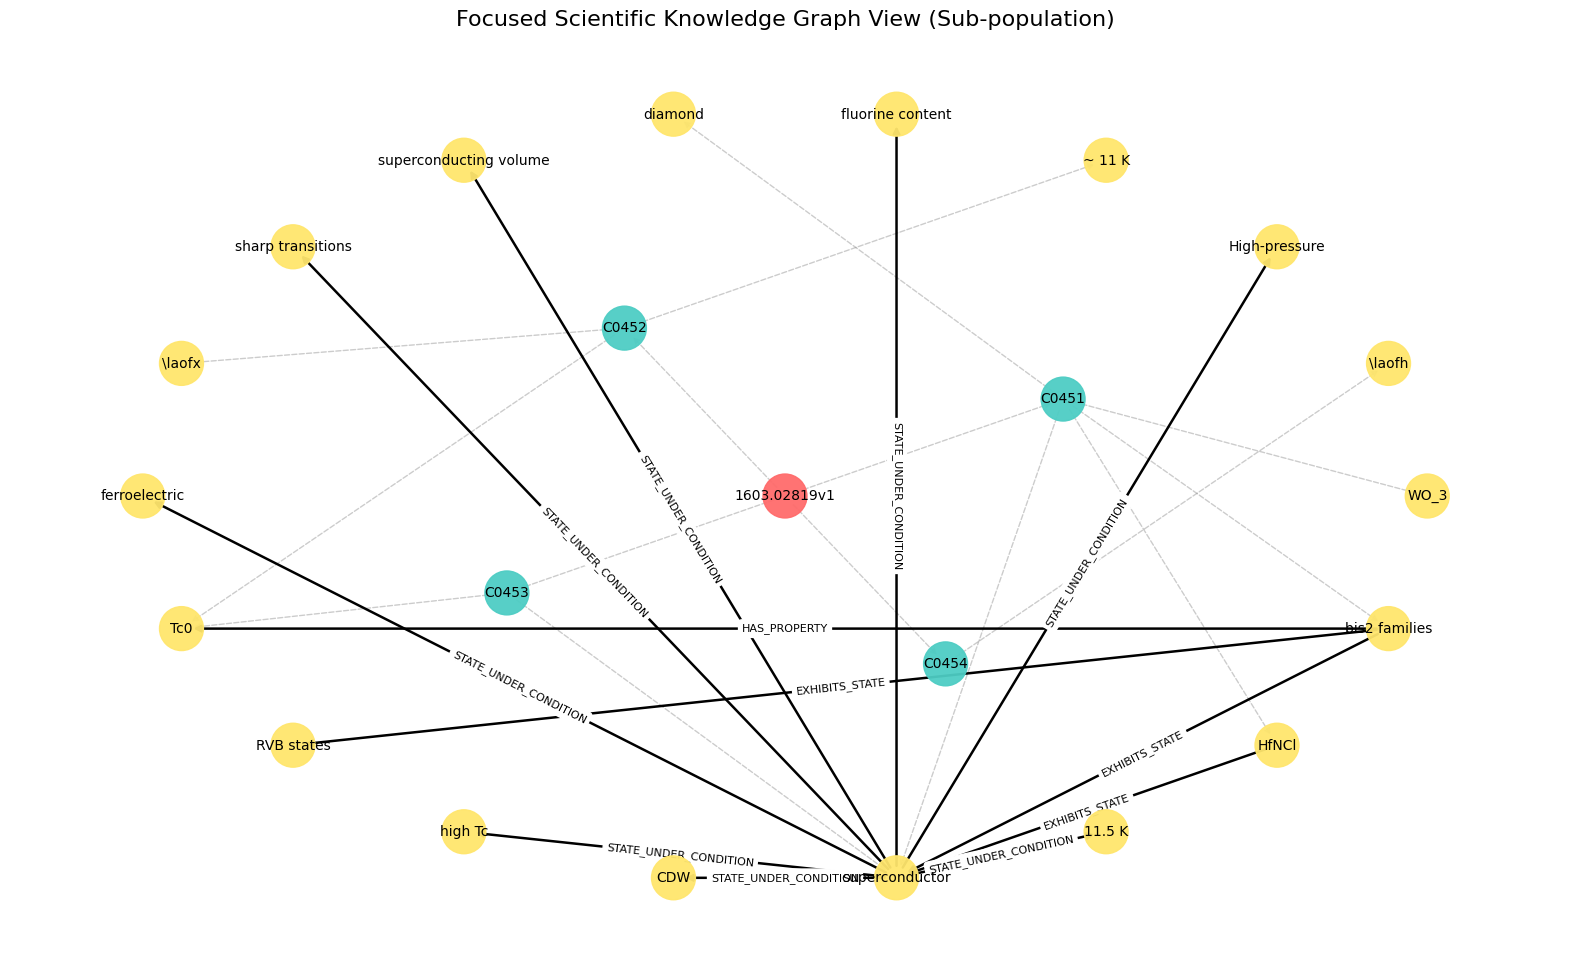

In [55]:
# --- Configuration for Readability ---
MAX_CLAIMS = 4
MAX_ENTITIES_PER_CLAIM = 5
MAX_FACT_EDGES = 12

# 1. Select the paper with the most claims (Highest Centrality)
paper_degrees = {n: d for n, d in G.out_degree() if G.nodes[n].get('type') == 'Article'}
target_paper = max(paper_degrees, key=paper_degrees.get)

nodes_to_draw = {target_paper}
fact_edges_to_draw = []

# 2. Extract specific claims for the target paper
claims = [n for n in G.successors(target_paper) if G.nodes[n].get('type') == 'Claim']
claims = claims[:MAX_CLAIMS]

for claim in claims:
    nodes_to_draw.add(claim)

    # 3. Select key entities based on importance (degree)
    entities = [n for n in G.successors(claim) if G.nodes[n].get('type') == 'Entity']
    entities = sorted(entities, key=lambda x: G.degree(x), reverse=True)[:MAX_ENTITIES_PER_CLAIM]

    for ent in entities:
        nodes_to_draw.add(ent)

        # 4. Filter for Semantic Fact Edges
        for u, v, d in G.out_edges(ent, data=True):
            if d.get('relation') not in ['HAS_CLAIM', 'MENTIONS_ENTITY']:
                if len(fact_edges_to_draw) < MAX_FACT_EDGES:
                    fact_edges_to_draw.append((u, v))
                    nodes_to_draw.add(v)

subgraph = G.subgraph(nodes_to_draw)

# 5. Define Shell Layout Structure
shell_0 = [n for n in subgraph.nodes if subgraph.nodes[n].get('type') == 'Article']
shell_1 = [n for n in subgraph.nodes if subgraph.nodes[n].get('type') == 'Claim']
shell_2 = [n for n in subgraph.nodes if subgraph.nodes[n].get('type') == 'Entity']

pos = nx.shell_layout(subgraph, nlist=[shell_0, shell_1, shell_2])

# 6. Plotting
plt.figure(figsize=(20, 12))

# Define Node Colors
node_colors = []
for node in subgraph.nodes:
    t = subgraph.nodes[node].get('type')
    if t == 'Article': node_colors.append('#ff6b6b')   # Soft Red
    elif t == 'Claim': node_colors.append('#4ecdc4')  # Teal
    else: node_colors.append('#ffe66d')              # Pale Yellow

nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=1000, alpha=0.95)

# Draw Structure Edges (Provenance)
structure_edges = [(u, v) for u, v, d in subgraph.edges(data=True)
                   if d.get('relation') in ['HAS_CLAIM', 'MENTIONS_ENTITY']]

nx.draw_networkx_edges(subgraph, pos, edgelist=structure_edges,
                       edge_color='gray', style='dashed', alpha=0.4)

# Draw Fact Edges (Semantic Knowledge)
nx.draw_networkx_edges(subgraph, pos, edgelist=fact_edges_to_draw,
                       edge_color='black', width=1.8)

# Map Labels
labels = {}
for n in subgraph.nodes:
    t = subgraph.nodes[n].get('type')
    if t == 'Article':
        labels[n] = subgraph.nodes[n].get('arxiv_id', n)
    elif t == 'Claim':
        labels[n] = n.split("::")[-1].replace("claim_", "C")
    else:
        labels[n] = n.split("::")[-1][:22] # Truncate long entity names

nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=10)

# Draw Semantic Edge Labels
edge_labels = {(u, v): G.edges[u, v, 0]['relation'] for u, v in fact_edges_to_draw if (u, v, 0) in G.edges}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Focused Scientific Knowledge Graph View (Sub-population)", fontsize=16)
plt.axis('off')
plt.show()

### Save the image to data/output

In [59]:
# Define output directory and filename
output_dir = '/content/drive/MyDrive/TFM/data/output/graph'
# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"localized_knowledge_graph_{timestamp}.png"
output_path = os.path.join(output_dir, output_filename)

# Save the currently active figure (the one generated by the previous cell)
plt.gcf().savefig(output_path, bbox_inches='tight', dpi=300)

print(f"Static knowledge graph image saved to: {output_path}")

Static knowledge graph image saved to: /content/drive/MyDrive/TFM/data/output/graph/localized_knowledge_graph_20260130_134504.png


<Figure size 640x480 with 0 Axes>

## 17. Advanced Analytics and Clustering

In this final phase, we analyze the structural properties of the Knowledge Graph. This allows us to move beyond individual claims and see the "big picture" of the corpus.

**Analytical Components:**
* **Sanitization:** Robust string cleaning to prevent encoding errors during graph rendering.
* **Centrality Analysis:** Identifying "Hubs" (nodes with high degrees) and "Bridges" (nodes with high betweenness) to find core scientific concepts.
* **Community Detection:** Using the **Louvain algorithm** to group entities into scientific topic clusters automatically.
* **Interactive Visualization:** A specialized PyVis setup with `ForceAtlas2` physics to make clusters visually distinct.


In [65]:
# --- Utility: String Sanitization ---
def sanitize_string(s):
    """Sanitizes strings to prevent UnicodeEncodeErrors in visualization."""
    if not isinstance(s, str): return s
    s = unicodedata.normalize('NFKC', s)
    s = ''.join(c for c in s if c.isprintable() or c.isspace())
    try:
        return s.encode('utf-8', errors='xmlcharrefreplace').decode('utf-8')
    except UnicodeEncodeError:
        return s.encode('utf-8', errors='replace').decode('utf-8')

# --- 1. Community Detection Setup ---
try:
    import community.community_louvain as community_louvain
    LOUVAIN_AVAILABLE = True
except ImportError:
    LOUVAIN_AVAILABLE = False

# --- 2. Graph Construction for Analytics ---
print("Building Graph for Analytics...")
G = nx.Graph() # Undirected for community detection
relation_counter = Counter()
claims_per_paper = []

for paper in corpus.get('papers', []):
    paper_id = sanitize_string(paper['arxiv_id'])
    G.add_node(paper_id, label=paper_id, group='Article', value=10)

    paper_claims_count = 0
    for claim in paper.get('extracted_data', []):
        claim_id = sanitize_string(claim['claim_id'])
        G.add_node(claim_id, label="Claim", group='Claim', value=5)
        G.add_edge(paper_id, claim_id, color='#bdbdbd')
        paper_claims_count += 1

        for trip in claim.get('triplets', []):
            s = sanitize_string(trip.get('subject_canonical', trip.get('subject')))
            o = sanitize_string(trip.get('object_canonical', trip.get('object')))
            r = sanitize_string(trip.get('relation'))

            G.add_node(s, label=s, group='Entity', value=3)
            G.add_node(o, label=o, group='Entity', value=3)

            # Fact & Provenance Edges
            G.add_edge(claim_id, s, color='#bdbdbd')
            G.add_edge(claim_id, o, color='#bdbdbd')
            G.add_edge(s, o, title=r, label=r, color='#2b7ce9')
            relation_counter[r] += 1

    claims_per_paper.append(paper_claims_count)

# --- 3. Run Analytics ---
print(f"\nGraph Built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
entity_nodes = [n for n, attr in G.nodes(data=True) if attr['group'] == 'Entity']
entity_subgraph = G.subgraph(entity_nodes)

# Centrality
degree_cent = nx.degree_centrality(entity_subgraph)
top_hubs = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]

print("\n--- TOP ENTITY HUBS ---")
for e, s in top_hubs:
    print(f" • {e:<35} {s:.4f}")

# Louvain Communities
if LOUVAIN_AVAILABLE and len(entity_subgraph.nodes) > 10:
    partition = community_louvain.best_partition(entity_subgraph)
    for node, comm_id in partition.items():
        G.nodes[node]['group'] = f"Cluster {comm_id}"
    print(f"\nDetected {len(set(partition.values()))} scientific topic communities.")

# --- 4. Interactive Visualization ---
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", notebook=True, cdn_resources='in_line')
net.force_atlas_2based()

# Pruning low-degree nodes for visual clarity
G_vis = G.copy()
low_degree_entities = [n for n in entity_nodes if G.degree(n) < 2]
G_vis.remove_nodes_from(low_degree_entities)

for node, attrs in G_vis.nodes(data=True):
    color = "#7be141" # Default Entity Green
    if attrs.get('group') == 'Article': color = "#ff6b6b"
    elif attrs.get('group') == 'Claim': color = "#ffff00"

    net.add_node(node, label=attrs.get('label'), color=color, size=attrs.get('value', 5))

for source, target, attrs in G_vis.edges(data=True):
    net.add_edge(source, target, color=attrs.get('color', '#cccccc'), label=attrs.get('label'))

net.show("scientific_clusters.html")

Building Graph for Analytics...

Graph Built: 2035 nodes, 5743 edges

--- TOP ENTITY HUBS ---
 • Tc0                                 0.1294
 • LaO0.5F0.5BiS2                      0.1125
 • Superconductivity                   0.0948
 • Bi4O4S3                             0.0533
 • LaO1-xFxBiS2                        0.0457

Detected 51 scientific topic communities.
scientific_clusters.html


## 18. Interactive Neighborhood Visualization (Plotly)

While large-scale graphs are best explored in PyVis, specific paper-centric "neighborhoods" are better analyzed using Plotly. This view allows for:
* **High-Fidelity Hovers:** Read full claim text by hovering over nodes.
* **Neighborhood Extraction:** Automatically centers on the most "active" paper (highest degree) and visualizes its immediate 2-hop ecosystem (Claims and Entities).
* **Deterministic Layout:** Uses a Spring Layout for consistent spatial distribution.


In [69]:
import glob
import os
import networkx as nx
import plotly.graph_objects as go

# --- 1. Load Data ---
input_file = ENRICHED_CORPUS_PATH

try:
    with open(input_file, 'r') as f:
        corpus = json.load(f)
except FileNotFoundError:
    # Fallback to finding the latest file
    list_of_files = glob.glob(os.path.join(os.path.dirname(ENRICHED_CORPUS_PATH), 'bis2_corpus_v1_enriched_*.json'))
    if list_of_files:
        latest_file = max(list_of_files, key=os.path.getctime)
        with open(latest_file, 'r') as f:
            corpus = json.load(f)
        print(f"Loaded latest corpus: {latest_file}")
    else:
        raise FileNotFoundError("No enriched corpus files found.")

# --- 2. Build Graph Structure ---
G = nx.MultiDiGraph() # Changed from nx.Graph() to nx.MultiDiGraph()

for paper in corpus['papers']:
    paper_id = paper['arxiv_id']
    title = paper.get('title', 'No Title')

    # Article Nodes (Red)
    G.add_node(paper_id, node_type='Article', label=title, color='#EF553B', size=20)

    for claim in paper.get('extracted_data', []):
        claim_id = claim['claim_id']
        claim_text = claim.get('claim_text', 'No text')

        # Claim Nodes (Green)
        G.add_node(claim_id, node_type='Claim', label=claim_text[:30]+"...",
                   full_text=claim_text, color='#00CC96', size=10)
        G.add_edge(paper_id, claim_id, edge_type='structure')

        for trip in claim.get('triplets', []):
            s = trip.get('subject_canonical', trip.get('subject'))
            o = trip.get('object_canonical', trip.get('object'))
            rel = trip.get('relation')

            # Entity Nodes (Blue)
            G.add_node(s, node_type='Entity', label=s, color='#636EFA', size=8)
            G.add_node(o, node_type='Entity', label=o, color='#636EFA', size=8)

            # Fact & Structure Edges
            G.add_edge(claim_id, s, edge_type='structure')
            G.add_edge(claim_id, o, edge_type='structure')
            G.add_edge(s, o, edge_type='fact', relation=rel)

# --- 3. Neighborhood Selection ---
paper_nodes = [n for n, attr in G.nodes(data=True) if attr['node_type'] == 'Article']
degrees = dict(G.degree(paper_nodes))
center_node = max(degrees, key=degrees.get)

# Extract 2-hop neighborhood
subset_nodes = set([center_node])
for neighbor in G.neighbors(center_node):
    subset_nodes.add(neighbor)
    for next_neighbor in G.neighbors(neighbor):
        subset_nodes.add(next_neighbor)

subgraph = G.subgraph(subset_nodes)

# --- 4. Prepare Visual Traces ---
pos = nx.spring_layout(subgraph, seed=42, k=0.5)

# Edges
edge_x, edge_y = [], []
for edge in subgraph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')

# Nodes
node_x, node_y, node_text, node_color, node_size = [], [], [], [], []
for node in subgraph.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    attrs = subgraph.nodes[node]
    node_color.append(attrs.get('color', '#999'))
    node_size.append(attrs.get('size', 10))

    label_prefix = f"<b>{attrs.get('node_type')}:</b>"
    node_text.append(f"{label_prefix}<br>{attrs.get('full_text', attrs.get('label', ''))}")

node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text',
                        text=node_text, marker=dict(color=node_color, size=node_size, line_width=2))

# --- 5. Render ---
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title=f'Knowledge Graph Neighborhood: {center_node}',
                hovermode='closest',
                showlegend=False,
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
fig.show()

## 19. Exporting Results

Finally, we export the structured graph data into tabular formats (CSV). This allows for easy inclusion in the dissertation appendix and facilitates further statistical analysis in tools like Excel or R.

**Outputs:**
1.  `entities_summary.csv`: A list of all unique entities, their canonical labels, and their degree centrality (connectivity).
2.  `relations_summary.csv`: A complete list of all extracted semantic triplets with their associated claims and effects.


In [67]:
# --- 1. Define Output Directory ---
RESULTS_DIR = Path("/content/drive/MyDrive/TFM/results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# --- 2. Create Entities Summary Dataframe ---
entity_list = []
for node, data in G.nodes(data=True):
    # Adjust 'Entity' check based on your specific node group labels
    if data.get('group') == 'Entity' or data.get('node_type') == 'Entity':
        entity_list.append({
            'entity_id': node,
            'label': data.get('label', node),
            'type': data.get('group', 'Entity'),
            'degree': G.degree(node),
            'variants': data.get('variants', [])
        })

df_entities = pd.DataFrame(entity_list)
df_entities = df_entities.sort_values('degree', ascending=False)

# --- 3. Create Relations Summary Dataframe ---
relations_list = []
for source, target, data in G.edges(data=True):
    # We only export semantic relations (excluding structural ones like 'MENTIONS')
    if data.get('relation') and data.get('relation') != 'MENTIONS':
        relations_list.append({
            'source': source,
            'target': target,
            'relation': data.get('relation', ''),
            'effect': data.get('effect', ''),
            'claim_id': data.get('claim_id', 'N/A')
        })

df_relations = pd.DataFrame(relations_list)

# --- 4. Display and Save ---
print("### Top 20 Entities by Connectivity ###")
display(df_entities.head(20))

print(f"\nTotal semantic relations extracted: {len(df_relations)}")
print("\n### Relation Type Distribution ###")
display(df_relations['relation'].value_counts())

# Save to the TFM/results directory
entities_path = RESULTS_DIR / 'entities_summary.csv'
relations_path = RESULTS_DIR / 'relations_summary.csv'

df_entities.to_csv(entities_path, index=False)
df_relations.to_csv(relations_path, index=False)

print(f"\n[SUCCESS] Results stored at: {RESULTS_DIR}")

### Top 20 Entities by Connectivity ###


,entity_id,label,type,degree,variants
24,LaO0.5F0.5BiS2,LaO0.5F0.5BiS2,Entity,320,[]
20,Tc0,Tc0,Entity,278,[]
14,Superconductivity,Superconductivity,Entity,212,[]
19,Bi4O4S3,Bi4O4S3,Entity,127,[]
41,LaO1-xFxBiS2,LaO1-xFxBiS2,Entity,94,[]
35,pressure,pressure,Entity,89,[]
57,F substitution,F substitution,Entity,82,[]
42,F concentration,F concentration,Entity,69,[]
1,resistivity,resistivity,Entity,69,[]
90,superconducting transition temperature,superconducting transition temperature,Entity,62,[]



Total semantic relations extracted: 1987

### Relation Type Distribution ###


,count
relation,
EXHIBITS_STATE,455
HAS_PROPERTY,368
PROPERTY_UNDER_CONDITION,286
STATE_UNDER_CONDITION,235
HAS_PROPERTY_VALUE,230
HAS_CONDITION_VALUE,159
EXPERIMENT_CONDITIONS,77
MEASURES,76
DESCRIBES,49



[SUCCESS] Results stored at: /content/drive/MyDrive/TFM/results


## 20. Knowledge Graph Query Interface

To facilitate qualitative analysis, we implement a targeted query function. This utility allows the user to search for a specific entity (using fuzzy or substring matching) and retrieve all associated incoming and outgoing relations.

**Query Capabilities:**
* **Substring Search:** Finds entities even if only a partial name is provided (e.g., searching "Tc" finds "Tc onset", "high-Tc phase").
* **Directional Analysis:** Separates "Outgoing" facts (where the entity is the Subject) from "Incoming" facts (where the entity is the Object).
* **Metadata Retrieval:** Displays node degree and canonical labels alongside the raw text.


In [70]:
def query_entity_relations(entity_text: str, kg: nx.MultiDiGraph, max_results=10):
    """
    Query and display relations for a specific entity within the Knowledge Graph.

    Args:
        entity_text (str): The search string for the entity.
        kg (nx.MultiDiGraph): The constructed Knowledge Graph.
        max_results (int): Limit the number of matching entities displayed.
    """
    # 1. Find matching entity nodes
    matches = []
    for node, data in kg.nodes(data=True):
        if data.get('node_type') == 'Entity' or data.get('group') == 'Entity':
            # Check both node ID and 'text' attribute for matches
            node_label = str(data.get('label', '')).lower()
            if entity_text.lower() in node_label:
                matches.append(node)

    if not matches:
        print(f"No entities found matching '{entity_text}'")
        return

    print(f"Found {len(matches)} matching entities in the graph.\n")

    # 2. Iterate through matches and print local neighborhood
    for match in matches[:max_results]:
        data = kg.nodes[match]
        print(f"--- Entity Match: {match} ---")
        print(f"Node Type: {data.get('group', 'Entity')}")
        print(f"Global Degree (Connectivity): {kg.degree(match)}")

        # Outgoing relations (Entity as Subject)
        out_edges = list(kg.out_edges(match, data=True))
        if out_edges:
            print(f"\nOutgoing relations ({len(out_edges)}):")
            # Filter out structural edges for the query view
            semantic_out = [e for e in out_edges if e[2].get('relation') != 'MENTIONS']
            for _, target, edge_data in semantic_out[:8]:
                rel = edge_data.get('relation', 'connected_to')
                target_label = kg.nodes[target].get('label', target)
                eff = f" (effect: {edge_data['effect']})" if edge_data.get('effect') else ""
                print(f"   [{match}] --({rel})--> [{target_label}]{eff}")

        # Incoming relations (Entity as Object)
        in_edges = list(kg.in_edges(match, data=True))
        if in_edges:
            print(f"\nIncoming relations ({len(in_edges)}):")
            semantic_in = [e for e in in_edges if e[2].get('relation') != 'MENTIONS']
            for source, _, edge_data in semantic_in[:8]:
                rel = edge_data.get('relation', 'connected_to')
                source_label = kg.nodes[source].get('label', source)
                print(f"   [{source_label}] --({rel})--> [{match}]")

        print("\n" + "="*60 + "\n")

# --- Example Usage ---
# Use the MultiDiGraph 'G' constructed in previous sections
print("TESTING QUERY: Superconducting Material")
query_entity_relations("LaO0.5F0.5BiS2", G)

print("\n" + "#"*60 + "\n")
print("TESTING QUERY: Physical Property")
query_entity_relations("Tc", G)

TESTING QUERY: Superconducting Material
Found 2 matching entities in the graph.

--- Entity Match: LaO0.5F0.5BiS2 ---
Node Type: Entity
Global Degree (Connectivity): 594

Outgoing relations (278):
   [LaO0.5F0.5BiS2] --(HAS_PROPERTY)--> [Tc0]
   [LaO0.5F0.5BiS2] --(HAS_PROPERTY)--> [Tc0]
   [LaO0.5F0.5BiS2] --(HAS_PROPERTY)--> [Tc0]
   [LaO0.5F0.5BiS2] --(HAS_PROPERTY)--> [Tc0]
   [LaO0.5F0.5BiS2] --(HAS_PROPERTY)--> [Tc0]
   [LaO0.5F0.5BiS2] --(HAS_PROPERTY)--> [Tc0]
   [LaO0.5F0.5BiS2] --(HAS_PROPERTY)--> [Tc0]
   [LaO0.5F0.5BiS2] --(HAS_PROPERTY)--> [Tc0]

Incoming relations (316):
   [The high-pressure-synthesized ...] --(connected_to)--> [LaO0.5F0.5BiS2]
   [The high-pressure-synthesized ...] --(connected_to)--> [LaO0.5F0.5BiS2]
   [High-pressure synthesis] --(SYNTHESIZES)--> [LaO0.5F0.5BiS2]
   [High-pressure synthesis] --(SYNTHESIZES)--> [LaO0.5F0.5BiS2]
   [High-pressure synthesis] --(SYNTHESIZES)--> [LaO0.5F0.5BiS2]
   [High-pressure synthesis] --(SYNTHESIZES)--> [LaO0.5F0.5Bi

## 21. Download All Results

In [ ]:
# Create a zip file with all outputs (optional)
import zipfile
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_filename = f"bis2_kg_results_{timestamp}.zip"

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    files_to_zip = [
        'extracted_relations.json',
        'knowledge_graph.gexf',
        'knowledge_graph.html',
        'entities_summary.csv',
        'relations_summary.csv'
    ]

    for filename in files_to_zip:
        if Path(filename).exists():
            zipf.write(filename)
            print(f"Added {filename} to archive")

print(f"\nCreated archive: {zip_filename}")
print(f"Total size: {Path(zip_filename).stat().st_size / (1024*1024):.2f} MB")


## 21. Project Completion & Summary

With the execution of this notebook, the automated pipeline for **Scientific Knowledge Graph Construction** is now complete. We have successfully transitioned from raw unstructured PDF data to a semantically enriched, queryable network of Materials Science facts.

### 21.1 Final Pipeline Achievements

* **Automated Relation Extraction:** Leveraged **Qwen 3 8B** to identify complex scientific relationships with strict unidirectional rules.
* **Knowledge Synthesis:** Aggregated disparate claims from the arXiv corpus into a unified graph structure.
* **Thematic Discovery:** Identified emergent scientific communities and topic clusters through Louvain community detection.
* **Data Persistence:** Generated structured CSV summaries and interactive visualizations for final dissertation reporting.

### 21.2 Results Checklist

The following assets have been generated and stored in `/TFM/results/`:

* [ ] `simplified_extracted_relations_...jsonl`: Raw structured model outputs.
* [ ] `entities_summary.csv`: Connectivity ranking of all extracted materials and properties.
* [ ] `relations_summary.csv`: Master list of all semantic triplets and their effects.
* [ ] `knowledge_graph.html`: Full interactive visualization.
* [ ] `scientific_clusters.html`: Community-based thematic visualization.

### 21.3 Final Conclusion

This pipeline demonstrates the feasibility of using quantized LLMs to automate the synthesis of materials science literature. The resulting Knowledge Graph provides a foundation for future discovery, allowing for rapid querying of material properties across thousands of research papers.

**This marks the conclusion of the 7-notebook series for this Master's Dissertation.**

THANK YOU FOR READING!